In [58]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt

from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings

import model_methods

___
## Read in Cleaned Post CSV

### Import CSV V1

In [2]:
df_posts = pd.read_csv('../data/cleaned_NVIDIA_AMD.csv', low_memory=False, index_col=0)

Drop additional columns

In [3]:
df_posts.drop(columns=['author','num_comments'], inplace=True)

Combine text columns into 1

In [4]:
df_posts['text']= df_posts['selftext'] + ' ' + df_posts['title']

Change subreddit to binary labels

### Import CSV V2

In [23]:
df_posts = pd.read_csv('../data/v2cleaned_NVIDIA_AMD.csv', low_memory=False, index_col=0)

In [24]:
df_posts.head()

,subreddit,text
1,nvidia,NvidiaProfileInspector or NvidiaInspector Whic...
2,nvidia,shadowplay is wierdpease help me before march ...
4,nvidia,Nvidia Gefore GTX 1060 6gb replacement options...
5,nvidia,Did latest driver update break features like R...
6,nvidia,Msi Suprim 3080 ti downclock itself by 250mhz ...


### CSV V3 Balanced

In [57]:
df_posts = pd.read_csv('../data/v2cleaned_NVIDIA_AMD.csv', low_memory=False, index_col=0)

In [59]:
df_posts['subreddit'].value_counts()

Amd       113376
nvidia     72769
Name: subreddit, dtype: int64

In [60]:
df_majority = df_posts[df_posts['subreddit'] == 'Amd']
df_minority = df_posts[df_posts['subreddit'] == 'nvidia']
df_majority.shape, df_minority.shape

((113376, 2), (72769, 2))

In [61]:
df_majority_downsampled = df_majority.sample(n=72769, random_state=42)

In [62]:
df_majority_downsampled.shape

(72769, 2)

In [63]:
df_balanced = pd.concat([df_majority_downsampled, df_minority])

In [64]:
df_balanced['subreddit'].value_counts()

Amd       72769
nvidia    72769
Name: subreddit, dtype: int64

In [65]:
df_posts = df_balanced

In [66]:
df_posts.shape

(145538, 2)

## Set Binary Values for Target

In [67]:
df_posts['subreddit'] = df_posts['subreddit'].apply(lambda x: 1 if x=='nvidia' else 0)

In [68]:
df_posts.head()

,subreddit,text
184272,0,Saphire Rx 5700xt Blower Help undervolt hi i ...
349092,0,Fk me after 1 Month of trying things I disable...
362639,0,X370 taichi just bricked what should i do So i...
177787,0,Just wondering Do you think its a good idea to...
188212,0,AMD PSP Does any of the A105800k or A105700 de...


Reset index

In [69]:
df_posts = df_posts.reset_index(drop=True)

In [70]:
df_posts.head()

,subreddit,text
0,0,Saphire Rx 5700xt Blower Help undervolt hi i ...
1,0,Fk me after 1 Month of trying things I disable...
2,0,X370 taichi just bricked what should i do So i...
3,0,Just wondering Do you think its a good idea to...
4,0,AMD PSP Does any of the A105800k or A105700 de...


___

### Preprocessing

In [71]:
X = df_posts[['text']]
y = df_posts['subreddit']

Lower text for Tokenization, Stop word removal, and Stemming

In [72]:
# lower text in preparation for token and stem
X['text'].str.lower()

0         saphire rx 5700xt blower help undervolt hi  i ...
1         fk me after 1 month of trying things i disable...
2         x370 taichi just bricked what should i do so i...
3         just wondering do you think its a good idea to...
4         amd psp does any of the a105800k or a105700 de...
                                ...                        
145533    nvidia geforce gtx 980 help so my last post wa...
145534    can i graph my gpu usage while i game i want t...
145535    turn shadowplay onoff with hotkey im running a...
145536    mosfet locations on my cards \ngtx 770 classif...
145537    is the shadowplay key configuration locked to ...
Name: text, Length: 145538, dtype: object

In [73]:
X.shape

(145538, 1)

___
### Baseline Model: 61% for V1 and V2, 50% for V3

In [74]:
y.value_counts(normalize=True)

0    0.5
1    0.5
Name: subreddit, dtype: float64

In [75]:
baseline = y.value_counts(normalize=True)[0]

In [76]:
baseline

0.5

___
### Train & Test Split

In [77]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [78]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((97510, 1), (48028, 1), (97510,), (48028,))

___
### Tokenize, Remove Stopwords, Stem

See model_methods.py and tokenize_pool_processing function for details

- one difference so far between (other than split sizes) between v1 and v2:
    - we needed to astype X_train, and X_test as string before being able to tokenize

In [79]:
Xdf_dict = {'X_train': X_train.astype(str), 'X_test': X_test.astype(str)}

In [80]:
start_time = time.time()
Xdf_processed_dict = model_methods.tokenize_pool_processing(Xdf_dict)
end_time = time.time()
print("total time taken: ", end_time-start_time)

total time taken:  34.530007123947144


In [81]:
X_train_proc = Xdf_processed_dict['X_train']['text'].astype(str)
X_test_proc = Xdf_processed_dict['X_test']['text'].astype(str)

In [82]:
X_train_proc.shape, X_test_proc.shape

((97510,), (48028,))

___

### Get Best Params Per Model

- Randomized Search CV takes `model tuples` and associating `params_grids` as parameters when finding the best hyperparameters.
- We have created a dictionary called model_dict to store various models and their associated param grids for future use, saved in the model_methods.py file.
- This portion of the notebook is dedicated to looping through and running the 6 different estimators through `RandomizedSearchCV` to find the best params for each estimator while saving time and resources.
- Estimators used in this project are:
    - `MultinomialNB`
    - `BernoulliNB`
    - `RandomForestClasssifier`
    - `LogisticRegression`
    - `AdaBoostClassifier`
    - `BaggingClassifier`
- Once each respective best version has been found we can run it through our evaluation function to capture:
    - `Train and Test Accuracy`
    - `Balanced Accuracy`
    - `Recall`
    - `Precision`
    - `F1`
- Then plot the confusion matrix and analyze peformance

### Find best models

In [83]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    
    start_time = time.time()
    best_models = model_methods.get_best_models(X_train_proc, y_train)
    end_time = time.time()
    print("total time taken: ", end_time-start_time)

Pipeline(steps=[('tfv', TfidfVectorizer()), ('mnb', MultinomialNB())])
Pipeline(steps=[('tfv', TfidfVectorizer()), ('bnb', BernoulliNB())])
Pipeline(steps=[('tfv', TfidfVectorizer()), ('rfc', RandomForestClassifier())])
Pipeline(steps=[('tfv', TfidfVectorizer()),
                ('logreg', LogisticRegression(max_iter=1000))])
Pipeline(steps=[('tfv', TfidfVectorizer()), ('abc', AdaBoostClassifier())])
Pipeline(steps=[('tfv', TfidfVectorizer()), ('bgc', BaggingClassifier())])
total time taken:  881.2477009296417


- After cleaning the data further, v2's RandomizedSearchCV took a whole 10minutes less than v1s which took 30 mins
- V3, with a total observation count of 97,510 for Xtrain, ook only 15 mins

___
### Record scores

___
#### First Time Calling Record_Scores Function


- Code is commented out because we are running v2 and do not want to overwrite the data

In [43]:
# start_time = time.time()
# initial_scores = model_methods.record_scores(baseline, X_train_proc,y_train,X_test_proc,y_test,best_models,model_name='only_null_clean')
# end_time = time.time()
# print("total time taken: ", end_time-start_time)

In [26]:
initial_scores.to_csv('../data/model_scores.csv')

___

#### Subsequent Record_Scores Function Calls

#### V2

In [49]:
initial_scores = pd.read_csv('../data/model_scores.csv', index_col=0)

In [50]:
initial_scores.head()

,version,baseline,model_type,train_acc,test_acc,bal_acc,recall,precision,f1_score
only_null_clean_mnb,v1,0.612821,mnb,0.922688,0.920442,0.911723,0.873078,0.917450,0.894714
only_null_clean_bnb,v1,0.612821,bnb,0.908666,0.905458,0.911224,0.936779,0.838103,0.884698
only_null_clean_rfc,v1,0.612821,rfc,0.749465,0.747951,0.675464,0.354207,0.985554,0.521123
only_null_clean_logreg,v1,0.612821,logreg,0.952307,0.943915,0.939337,0.919046,0.934991,0.926950
only_null_clean_abc,v1,0.612821,abc,0.930609,0.926225,0.918441,0.883941,0.922285,0.902706


In [51]:
v2_scores = model_methods.record_scores(baseline, X_train_proc,y_train,X_test_proc,y_test,best_models,model_name='full_clean', df_scores=initial_scores)

In [84]:
v2_scores.head(12)

,version,baseline,model_type,train_acc,test_acc,bal_acc,recall,precision,f1_score
only_null_clean_mnb,v1,0.612821,mnb,0.922688,0.920442,0.911723,0.873078,0.917450,0.894714
only_null_clean_bnb,v1,0.612821,bnb,0.908666,0.905458,0.911224,0.936779,0.838103,0.884698
only_null_clean_rfc,v1,0.612821,rfc,0.749465,0.747951,0.675464,0.354207,0.985554,0.521123
only_null_clean_logreg,v1,0.612821,logreg,0.952307,0.943915,0.939337,0.919046,0.934991,0.926950
only_null_clean_abc,v1,0.612821,abc,0.930609,0.926225,0.918441,0.883941,0.922285,0.902706
only_null_clean_bgc,v1,0.612821,bgc,0.783045,0.781908,0.725565,0.475858,0.924002,0.628196
full_clean_mnb,v2,0.609126,mnb,0.923477,0.920244,0.911763,0.872907,0.918983,0.895353
full_clean_bnb,v2,0.609126,bnb,0.920566,0.918600,0.915420,0.900850,0.891972,0.896389
full_clean_rfc,v2,0.609126,rfc,0.748888,0.746602,0.677102,0.358666,0.980979,0.525279
full_clean_logreg,v2,0.609126,logreg,0.950294,0.942250,0.937071,0.913342,0.937308,0.925170


In [53]:
v2_scores.to_csv('../data/model_scores.csv')

#### V3

In [85]:
v3_scores = model_methods.record_scores(baseline, X_train_proc,y_train,X_test_proc,y_test,best_models,model_name='balanced', df_scores=v2_scores)

In [89]:
v3_scores.tail(6)

,version,baseline,model_type,train_acc,test_acc,bal_acc,recall,precision,f1_score
balanced_mnb,v3,0.5,mnb,0.922572,0.918256,0.918256,0.926460,0.911504,0.918921
balanced_bnb,v3,0.5,bnb,0.919136,0.915674,0.915674,0.908803,0.921466,0.915091
balanced_rfc,v3,0.5,rfc,0.903959,0.902078,0.902078,0.951278,0.866058,0.906670
balanced_logreg,v3,0.5,logreg,0.949605,0.937870,0.937870,0.941784,0.934468,0.938112
balanced_abc,v3,0.5,abc,0.922223,0.916403,0.916403,0.957441,0.884818,0.919698
balanced_bgc,v3,0.5,bgc,0.854312,0.853065,0.853065,0.778671,0.914779,0.841255


In [98]:
v3_scores.to_csv('../data/model_scores.csv')

___

#### Confusion Matrix Generator Version 1

In [37]:
best_preds = {}

for model, model_dict in best_models.items():
    model_dict['model'].fit(X_test_proc, y_test)
    preds = model_dict['model'].predict(X_test_proc)
    best_preds[model] = preds

In [38]:
best_preds

{'mnb': array([0, 0, 0, ..., 0, 1, 0]),
 'bnb': array([0, 0, 0, ..., 1, 1, 0]),
 'rfc': array([0, 0, 0, ..., 0, 0, 0]),
 'logreg': array([0, 0, 0, ..., 1, 1, 0]),
 'abc': array([0, 0, 0, ..., 1, 1, 0]),
 'bgc': array([0, 0, 0, ..., 0, 1, 0])}

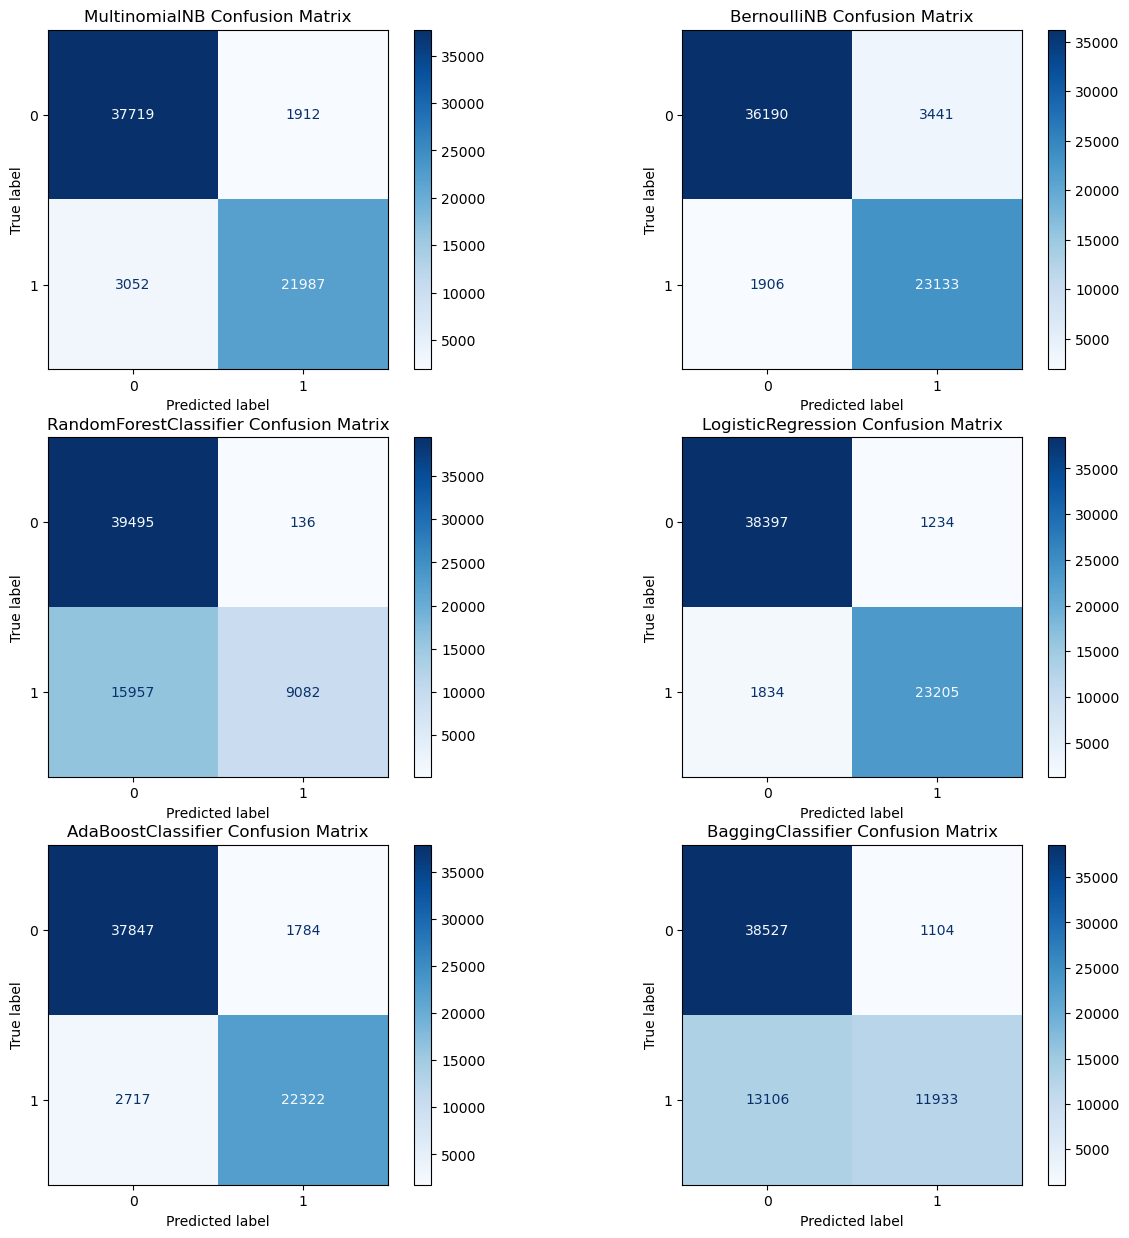

In [54]:
fig, axes = plt.subplots(3,2,figsize=(15,15))
axes[0,0].set_title("MultinomialNB Confusion Matrix")
axes[0,1].set_title("BernoulliNB Confusion Matrix")
axes[1,0].set_title("RandomForestClassifier Confusion Matrix")
axes[1,1].set_title("LogisticRegression Confusion Matrix")
axes[2,0].set_title("AdaBoostClassifier Confusion Matrix")
axes[2,1].set_title("BaggingClassifier Confusion Matrix")

ConfusionMatrixDisplay(
confusion_matrix = confusion_matrix(y_test, best_preds['mnb'])).plot(ax=axes[0,0],cmap="Blues")

ConfusionMatrixDisplay(
confusion_matrix = confusion_matrix(y_test, best_preds['bnb'])).plot(ax=axes[0,1],cmap="Blues")

ConfusionMatrixDisplay(
confusion_matrix = confusion_matrix(y_test, best_preds['rfc'])).plot(ax=axes[1,0],cmap="Blues")

ConfusionMatrixDisplay(
confusion_matrix = confusion_matrix(y_test, best_preds['logreg'])).plot(ax=axes[1,1],cmap="Blues")

ConfusionMatrixDisplay(
confusion_matrix = confusion_matrix(y_test, best_preds['abc'])).plot(ax=axes[2,0],cmap="Blues")

ConfusionMatrixDisplay(
confusion_matrix = confusion_matrix(y_test, best_preds['bgc'])).plot(ax=axes[2,1],cmap="Blues");

### Version 1 Performance Analysis

- For purposes of ranking and analysis, the top 3 performers this first round in which we only cleaned out null values are:
    - LogisticRegression: 38,397 TN, 23,205 TP
    - AdaBoostClassifier: 37,847 TN, 22,322 TP
    - MultinomialNB: 37,719 TN, 21,987 TP
- Bottom 3 Peformers are:
    - BernoulliNB: 36,190 TN, 23,133 TP
    - BaggingClassifier: 38,527 TN, 11,933 TP
    - RandomForestClassifier: 39,495 TN, 9082 TP
- Both of the NaiveBayes models performed really well and similarly. The False Negatives and False Positive performance of both is almost reversed as well. MNB was better at predicting True Negatives, while BNB was better at predicting True Positives.
    - This could be explained by the imbalance of the subreddit population with ~2/3s being AMD and the other third being NVIDIA.
    - MNB assumes that the features are generated from a multinomial distribution, if the words that are indicative of NVIDIA(1) are less frequent than those of AMD(0), it will have a higher bias towards AMD
    - BNB assumes that the features are generated from a Bernoulli distribution where each feature is a binary variable, if the words that are indicative of NVIDIA(1) are more rare than words indicative of AMD(0), the model might be more biased towards NVIDIA.
    - All in all though, each model performed pretty well on a null_only clean.
- LogisticRegression performed the best probably because it is a linear model that can handle unbalanced datasets as it learns decisions by optimizing the max likelihood of the coefficients; whereas NB makes the assumption that features are independent and equally important.
- Every model however easily beat the baseline score of 61% looking at the below printout

In [55]:
initial_scores.head(6)

,version,baseline,model_type,train_acc,test_acc,bal_acc,recall,precision,f1_score
only_null_clean_mnb,v1,0.612821,mnb,0.922688,0.920442,0.911723,0.873078,0.91745,0.894714
only_null_clean_bnb,v1,0.612821,bnb,0.908666,0.905458,0.911224,0.936779,0.838103,0.884698
only_null_clean_rfc,v1,0.612821,rfc,0.749465,0.747951,0.675464,0.354207,0.985554,0.521123
only_null_clean_logreg,v1,0.612821,logreg,0.952307,0.943915,0.939337,0.919046,0.934991,0.92695
only_null_clean_abc,v1,0.612821,abc,0.930609,0.926225,0.918441,0.883941,0.922285,0.902706
only_null_clean_bgc,v1,0.612821,bgc,0.783045,0.781908,0.725565,0.475858,0.924002,0.628196


___
### Version 2

In [54]:
best_preds = {}

for model, model_dict in best_models.items():
    model_dict['model'].fit(X_test_proc, y_test)
    preds = model_dict['model'].predict(X_test_proc)
    best_preds[model] = preds

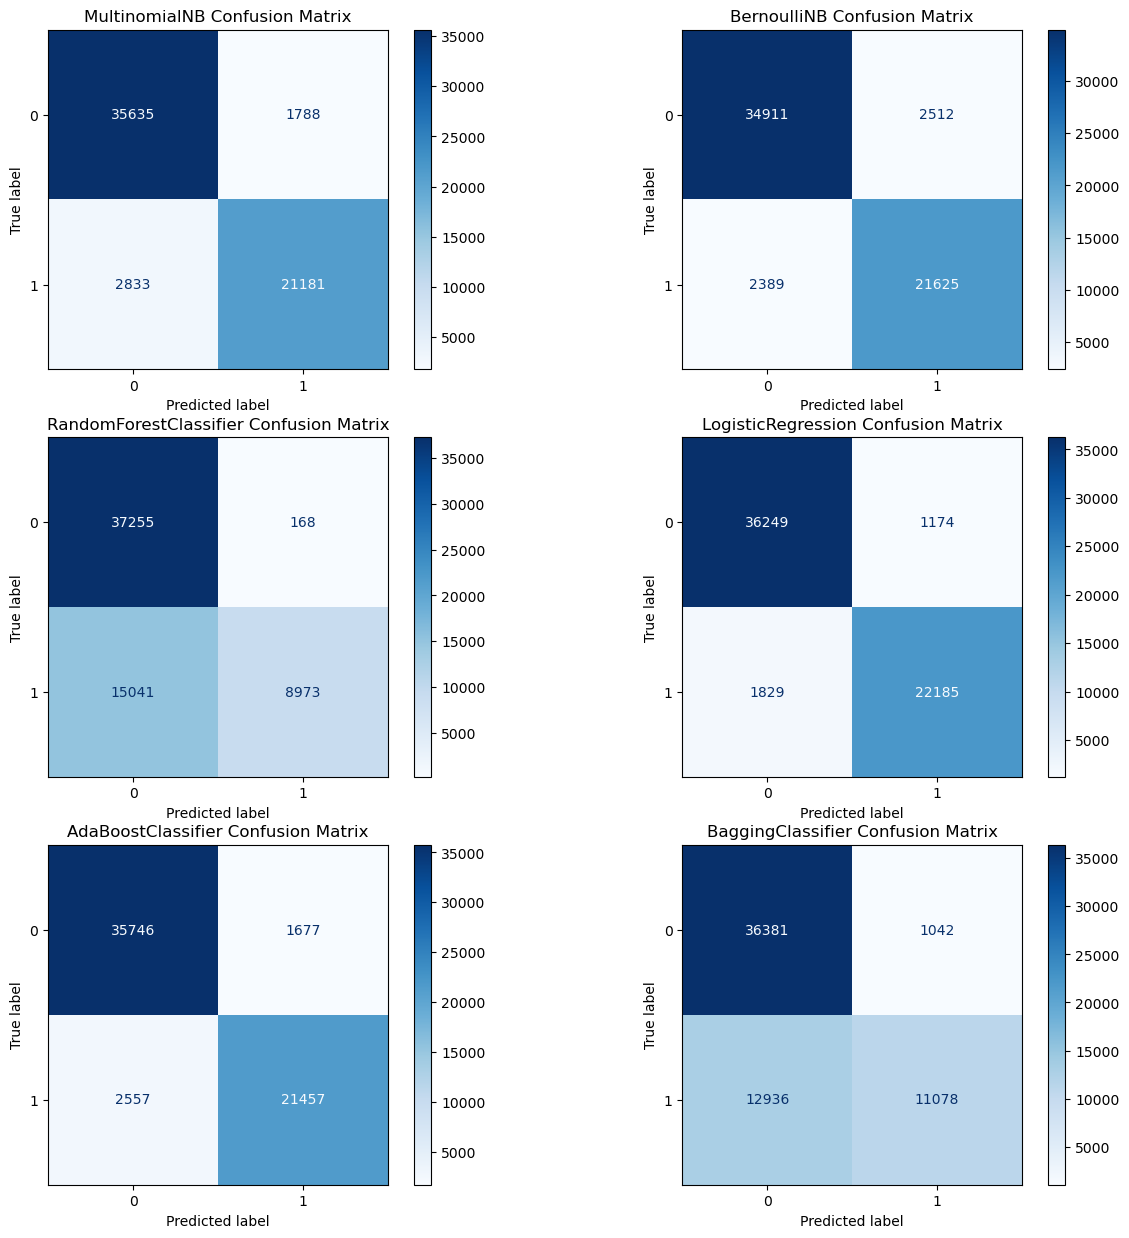

In [55]:
fig, axes = plt.subplots(3,2,figsize=(15,15))
axes[0,0].set_title("MultinomialNB Confusion Matrix")
axes[0,1].set_title("BernoulliNB Confusion Matrix")
axes[1,0].set_title("RandomForestClassifier Confusion Matrix")
axes[1,1].set_title("LogisticRegression Confusion Matrix")
axes[2,0].set_title("AdaBoostClassifier Confusion Matrix")
axes[2,1].set_title("BaggingClassifier Confusion Matrix")

ConfusionMatrixDisplay(
confusion_matrix = confusion_matrix(y_test, best_preds['mnb'])).plot(ax=axes[0,0],cmap="Blues")

ConfusionMatrixDisplay(
confusion_matrix = confusion_matrix(y_test, best_preds['bnb'])).plot(ax=axes[0,1],cmap="Blues")

ConfusionMatrixDisplay(
confusion_matrix = confusion_matrix(y_test, best_preds['rfc'])).plot(ax=axes[1,0],cmap="Blues")

ConfusionMatrixDisplay(
confusion_matrix = confusion_matrix(y_test, best_preds['logreg'])).plot(ax=axes[1,1],cmap="Blues")

ConfusionMatrixDisplay(
confusion_matrix = confusion_matrix(y_test, best_preds['abc'])).plot(ax=axes[2,0],cmap="Blues")

ConfusionMatrixDisplay(
confusion_matrix = confusion_matrix(y_test, best_preds['bgc'])).plot(ax=axes[2,1],cmap="Blues");

### Version 2 Performance Analysis

- For purposes of ranking and analysis, the top 3 performers this first round in which we only cleaned out null values are:
    - LogisticRegression: 36,249 TN, 22,185 TP
    - AdaBoostClassifier: 35,746 TN, 21,457 TP
    - MultinomialNB: 35,635 TN, 21,181 TP
- Bottom 3 Peformers are:
    - BernoulliNB: 34,911 TN, 21,625 TP
    - BaggingClassifier: 36,381 TN, 11,078 TP
    - RandomForestClassifier: 37,255 TN, 8973 TP
- Despite the increased cleaning techniques done for version 2, with the reduced population size in mind, the version 2 model did slightly worse on an accuracy and score basis.
- The data imbalance still exists and although slightly reduced the models performed in the exact same way as version 1, probably for similar reasons.
- LogisticRegression still performed the best.
- Once again every model easily beat the baseline score of 61%
- If this project is continued, for version 3 we will definitely try evening out the data distributions of subreddits to counter the data imbalance.

___

### Version 3

In [90]:
best_preds = {}

for model, model_dict in best_models.items():
    model_dict['model'].fit(X_test_proc, y_test)
    preds = model_dict['model'].predict(X_test_proc)
    best_preds[model] = preds

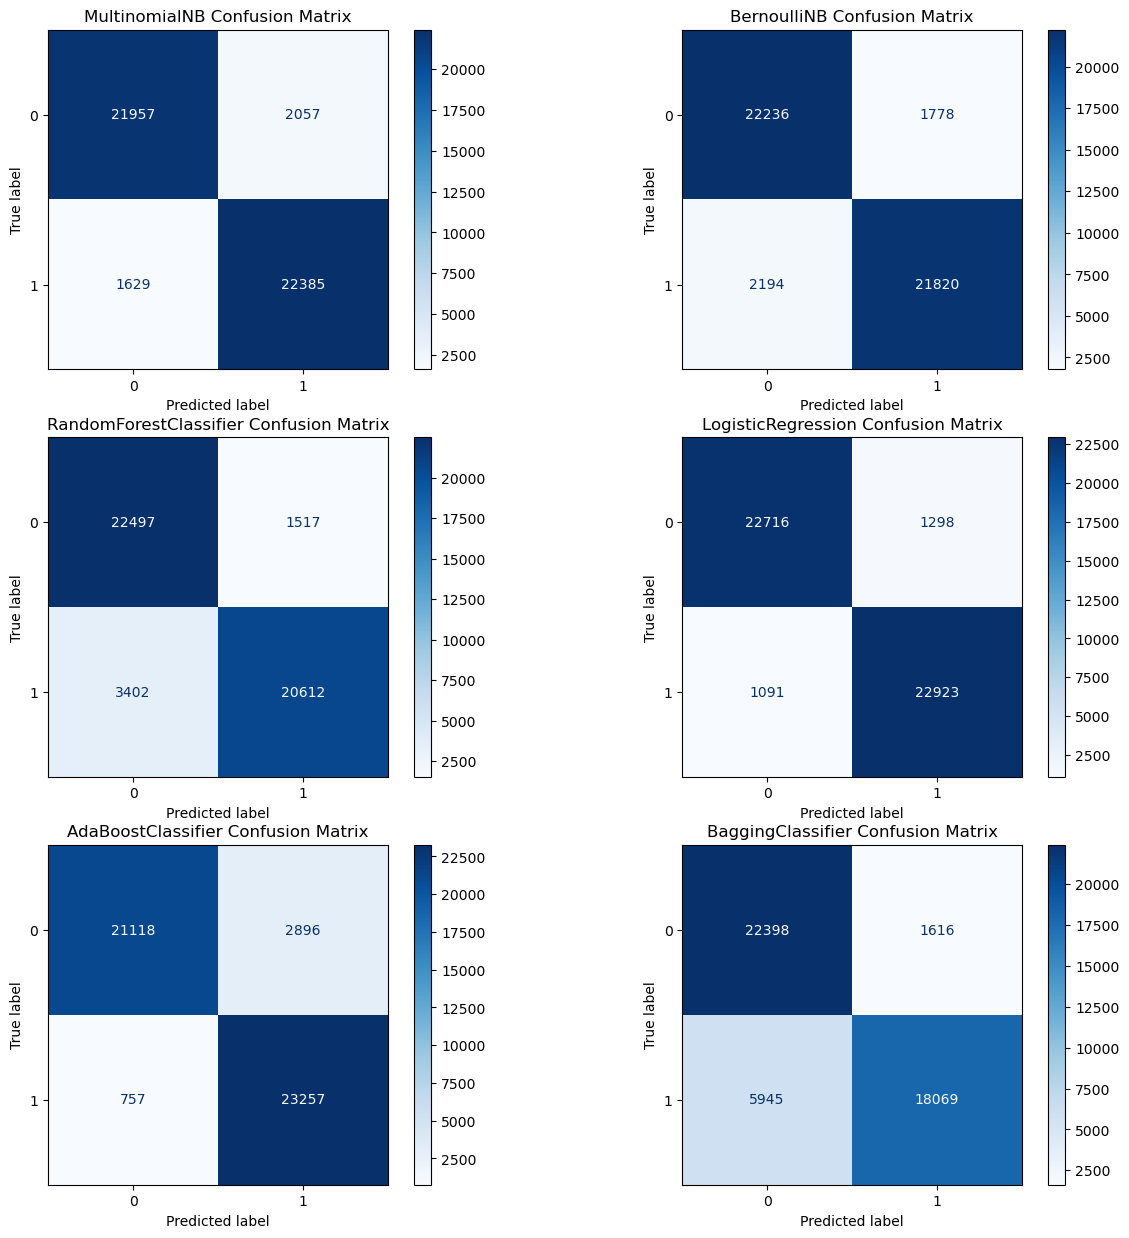

In [91]:
fig, axes = plt.subplots(3,2,figsize=(15,15))
axes[0,0].set_title("MultinomialNB Confusion Matrix")
axes[0,1].set_title("BernoulliNB Confusion Matrix")
axes[1,0].set_title("RandomForestClassifier Confusion Matrix")
axes[1,1].set_title("LogisticRegression Confusion Matrix")
axes[2,0].set_title("AdaBoostClassifier Confusion Matrix")
axes[2,1].set_title("BaggingClassifier Confusion Matrix")

ConfusionMatrixDisplay(
confusion_matrix = confusion_matrix(y_test, best_preds['mnb'])).plot(ax=axes[0,0],cmap="Blues")

ConfusionMatrixDisplay(
confusion_matrix = confusion_matrix(y_test, best_preds['bnb'])).plot(ax=axes[0,1],cmap="Blues")

ConfusionMatrixDisplay(
confusion_matrix = confusion_matrix(y_test, best_preds['rfc'])).plot(ax=axes[1,0],cmap="Blues")

ConfusionMatrixDisplay(
confusion_matrix = confusion_matrix(y_test, best_preds['logreg'])).plot(ax=axes[1,1],cmap="Blues")

ConfusionMatrixDisplay(
confusion_matrix = confusion_matrix(y_test, best_preds['abc'])).plot(ax=axes[2,0],cmap="Blues")

ConfusionMatrixDisplay(
confusion_matrix = confusion_matrix(y_test, best_preds['bgc'])).plot(ax=axes[2,1],cmap="Blues");

- For purposes of ranking and analysis, the top 3 performers this first round in which we only cleaned out null values are:
    - LogisticRegression: 22,716 TN, 22,923 TP
    - AdaBoostClassifier: 21,118 TN, 23,257 TP
    - MultinomialNB: 21,957 TN, 22,385 TP
- Bottom 3 Peformers are:
    - BernoulliNB: 22,236 TN, 21,820 TP
    - RandomForestClassifier: 22,497 TN, 20,612 TP
    - BaggingClassifier: 22,398 TN, 18,069 TP
- From a scores perspective, overall the main observation is the less data the less accurate your models will be. In this version, we balanced the datasets by cutting down the AMD Majority by matching the size with random undersampling to NVIDIA.
- Overall the models performed similarly to the past 3 versions, but unsurprisingly RandomForestClassifier shot up 1 spot in rank from 6th to 5th.
    - RandomForestClassifier is another ensemble method
    - In imbalanced datsets the model will develop a bias towards the majority class, as we saw in Versions 1 and 2 where it was much better at predicting True Negatives (AMD) than it was True Positives (NVIDIA)
        - Further proved by it's dramatically low recall scores in v1 and v2
    - The bias can form because RandomForestClassifier is trained on random subsets of features and examples, with an imbalanced dataset you are more likely to have examples of majority than minority.
- LogisticRegression still performed the best out of all 6 models.
- Once again every model easily beat the baseline score, this time of 50%. All our models are effective classifiers in regard to these two subreddits, some are just better than others based on their evaluation methods.
- If this project is continued, for version 4 we will definitely try a stacking model.